<a href="https://colab.research.google.com/github/eliassz/ML_DA-Coursera-MIPT_Yandex/blob/main/RIPE_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/kinosal/predictor.git

Cloning into 'predictor'...
remote: Enumerating objects: 441, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 441 (delta 12), reused 23 (delta 11), pack-reused 411
Receiving objects: 100% (441/441), 1.19 MiB | 7.99 MiB/s, done.
Resolving deltas: 100% (218/218), done.


In [4]:
!pip install scikit-optimize
!pip install catboost
!pip install xgboost

     |████████████████████████████████| 100 kB 4.6 MB/s 
     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

In [6]:
np.random.seed(1)

In [7]:
import sys
import os

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [10]:
import catboost
import xgboost
import lightgbm
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [11]:
# import psycopg2 as pg
# import boto3
import joblib

Structure:


1.   [First glance](#1)

2.   [Preprocessing](#2)
3.   [Regresssion](#3)
4.   [Training](#4)
5.   [Transfer](#5)


<a name="1"></a>
# 1. First glance


In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
# set figsize
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

# Expand displayed data rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [14]:
# Load data
data = pd.read_csv('/content/gdrive/MyDrive/RIPE.TECH/f_ads.csv')

In [15]:
data['Месяц'] = data['Месяц'].apply(lambda x: datetime.datetime.strptime(x.split(' ')[0], "%Y-%m-%d").month)

In [16]:
data['CPM'] = (data['Сумма затрат (RUB)'] / data['Показы'] * 1000).round(2)

In [17]:
data['Тип результата'].value_counts()

Лиды с сайта                  561
Лиды на Facebook               62
Клики по ссылке                10
Просмотры целевой страницы      3
Охват                           1
Name: Тип результата, dtype: int64

In [21]:
# is better to automize this moment
data = data[data['Тип результата'].isin(['Лиды с сайта', 'Лиды на Facebook'])]

In [28]:
def remove_outliers(df, column):
  return df[np.abs(df[column]-df[column].mean()) <= (3*df[column].std())]

In [29]:
data = remove_outliers(data, 'Результат')

In [30]:
leads = data.groupby('Месяц',as_index=False).agg({'Результат':'sum'})

In [31]:
leads['Выручка'] = pd.read_csv('/content/gdrive/MyDrive/RIPE.TECH/month-revenue.csv')['Бюджет ']

In [32]:
leads['K'] = leads['Выручка'] / leads['Результат']

In [33]:
leads

,Месяц,Результат,Выручка,K
0,1,618.0,19068.529595,30.855226
1,2,568.0,47434.900000,83.512148
2,3,453.0,56475.523316,124.670029
3,4,1412.0,52246.037433,37.001443
4,5,1994.0,50854.208556,25.503615
5,6,1347.0,61632.986395,45.755743
6,7,1095.0,55214.762887,50.424441
7,8,1488.0,61446.318182,41.294569
8,9,698.0,55846.290816,80.009013
9,10,580.0,65127.380368,112.288587


In [34]:
def k_revenue(x):
  return leads.iloc[x-1]['K']

In [35]:
data['K'] = data['Месяц'].map(lambda x: k_revenue(x))

In [36]:
data['Выручка'] = data['K']*data['Результат']

In [37]:
data

,Название кампании,Название группы объявлений,Месяц,Статус показа,Охват,Показы,Частота,Настройка атрибуции,Тип результата,Результат,Сумма затрат (RUB),Цена за результат,Начало,Конец,Клики по ссылке,CPC (цена за клик по ссылке),CTR (все),Лиды,Дата начала отчетности,Дата окончания отчетности,Статус компании,Дата начала отчетности (неделя),Дата начала отчетности (месяц),Дата начала отчетности (год),Дата окончания отчетности (неделя),Дата окончания отчетности (месяц),Дата окончания отчетности (год),Продолжительность в днях,CPM,K,Выручка
0,RV_Business analyst,LA new,12,inactive,11112.0,11765.0,1.058765,7 дней после клика или 1 день после просмотра,Лиды с сайта,2.0,4201.78,2100.890000,2021-06-11,Текущие,41.0,102.482439,0.484488,2.0,2021-12-01,2021-12-31,active,48,12,2021,52,12,2021,30,357.14,85.512860,171.025721
1,RV_Business analyst,LA new,11,inactive,304656.0,707159.0,2.321172,7 дней после клика или 1 день после просмотра,Лиды с сайта,82.0,272288.22,3320.588049,2021-06-11,Текущие,2231.0,122.047611,0.463545,82.0,2021-11-01,2021-11-30,active,44,11,2021,48,11,2021,29,385.05,95.084045,7796.891687
2,RV_Business analyst,LA new,10,inactive,340671.0,674409.0,1.979649,7 дней после клика или 1 день после просмотра,Лиды с сайта,71.0,180248.83,2538.715915,2021-06-11,Текущие,1812.0,99.475072,0.379740,71.0,2021-10-01,2021-10-31,active,39,10,2021,43,10,2021,30,267.27,112.288587,7972.489666
3,RV_Business analyst,LA new,9,inactive,8434.0,10104.0,1.198008,7 дней после клика или 1 день после просмотра,Лиды с сайта,5.0,3712.24,742.448000,2021-06-11,Текущие,48.0,77.338333,0.673001,5.0,2021-09-01,2021-09-30,active,35,9,2021,39,9,2021,29,367.40,80.009013,400.045063
4,RV_Business analyst,LA new,8,inactive,26098.0,32758.0,1.255192,7 дней после клика или 1 день после просмотра,Лиды с сайта,8.0,7956.98,994.622500,2021-06-11,Текущие,109.0,72.999817,0.476220,8.0,2021-08-01,2021-08-31,active,30,8,2021,35,8,2021,30,242.90,41.294569,330.356549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,RV_NewYear,retargeting from insta,1,not_delivering,0.0,0.0,0.000000,28 дней после клика или 1 день после просмотра,Лиды с сайта,1.0,0.00,0.000000,2020-12-20,2020-12-31,NaN,NaN,NaN,1.0,2021-01-01,2021-01-31,inactive,53,1,2021,4,1,2021,30,NaN,30.855226,30.855226
633,RV_Investmanager,Interests,1,not_delivering,0.0,0.0,0.000000,28 дней после клика или 1 день после просмотра,Лиды с сайта,1.0,0.00,0.000000,2020-11-24,Текущие,NaN,NaN,NaN,1.0,2021-01-01,2021-01-31,inactive,53,1,2021,4,1,2021,30,NaN,30.855226,30.855226
634,RV_CFA,Retargeting sites,1,not_delivering,0.0,0.0,0.000000,28 дней после клика или 1 день после просмотра,Лиды с сайта,1.0,0.00,0.000000,2020-11-21,Текущие,NaN,NaN,NaN,1.0,2021-01-01,2021-01-31,inactive,53,1,2021,4,1,2021,30,NaN,30.855226,30.855226
635,RV_CFA,Retargeting inst,1,not_delivering,0.0,0.0,0.000000,28 дней после клика или 1 день после просмотра,Лиды с сайта,1.0,0.00,0.000000,2020-11-21,Текущие,NaN,NaN,NaN,1.0,2021-01-01,2021-01-31,inactive,53,1,2021,4,1,2021,30,NaN,30.855226,30.855226


In [40]:
# Show data shape (size), columns
print(data.shape)
print(data.columns.values)

(528, 31)
['Название кампании' 'Название группы объявлений' 'Месяц' 'Статус показа'
 'Охват' 'Показы' 'Частота' 'Настройка атрибуции' 'Тип результата'
 'Результат' 'Сумма затрат (RUB)' 'Цена за результат' 'Начало' 'Конец'
 'Клики по ссылке' 'CPC (цена за клик по ссылке)' 'CTR (все)' 'Лиды'
 'Дата начала отчетности' 'Дата окончания отчетности' 'Статус компании'
 'Дата начала отчетности (неделя)' 'Дата начала отчетности (месяц)'
 'Дата начала отчетности (год)' 'Дата окончания отчетности (неделя)'
 'Дата окончания отчетности (месяц)' 'Дата окончания отчетности (год)'
 'Продолжительность в днях' 'CPM' 'K' 'Выручка']


In [ ]:
# d = {'Название группы объявлений':'count', 
#     'Показы': 'sum', 
#     'Настройка атрибуции': pd.Series.mode, 
#     'Тип результата': pd.Series.mode, 
#     'Сумма затрат (RUB)':'sum',
#     'Дата начала отчетности (неделя)':'min',
#     'Дата начала отчетности (месяц)' : 'min',
#      'Дата начала отчетности (год)' : 'min',
#     'Дата окончания отчетности (неделя)':'max',
#      'Дата окончания отчетности (месяц)' : 'max',
#      'Дата окончания отчетности (год)' : 'max'}

In [ ]:
# data = data.groupby(['Название кампании'],as_index=False).agg(d)

In [ ]:
# data.rename(columns={'Название группы объявлений':'Количество слотов'}, inplace=True)

In [ ]:
# output = 'Показы_ср'

In [ ]:
# data['Показы_ср'] = (data['Показы'] / data['Количество слотов']).round(1)

In [ ]:
# data.drop(['Дата начала отчетности (год)','Дата окончания отчетности (год)','Показы','Количество слотов'], axis=1, inplace=True)

In [41]:
# View metrics summary
data.describe()

,Месяц,Охват,Показы,Частота,Результат,Сумма затрат (RUB),Цена за результат,Клики по ссылке,CPC (цена за клик по ссылке),CTR (все),Лиды,Дата начала отчетности (неделя),Дата начала отчетности (месяц),Дата начала отчетности (год),Дата окончания отчетности (неделя),Дата окончания отчетности (месяц),Дата окончания отчетности (год),Продолжительность в днях,CPM,K,Выручка
count,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,515.000000,515.000000,517.000000,528.000000,528.000000,528.000000,528.0,528.000000,528.000000,528.0,528.000000,515.000000,528.000000,528.000000
mean,6.962121,41806.350379,71329.784091,1.708587,21.787879,45022.366837,4882.479066,239.293204,262.373779,0.615609,21.787879,28.160985,6.962121,2021.0,30.174242,6.962121,2021.0,29.486742,882.325903,59.596444,1209.510162
std,3.005764,50680.425809,93111.729498,0.852237,33.981808,51960.748444,6367.780848,301.980488,197.865440,0.334048,33.981808,13.028164,3.005764,0.0,13.120372,3.005764,0.0,0.699562,725.233553,29.333643,1877.182413
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,34.830655,0.118898,1.000000,5.000000,1.000000,2021.0,4.000000,1.000000,2021.0,27.000000,128.490000,25.503615,25.503615
25%,5.000000,8933.500000,13578.000000,1.236461,3.000000,10592.202500,1012.225348,52.000000,119.821417,0.426472,3.000000,17.000000,5.000000,2021.0,22.000000,5.000000,2021.0,29.000000,423.690000,37.001443,170.025365
50%,6.000000,24226.500000,41501.500000,1.476840,9.000000,29048.050000,2757.152143,135.000000,199.861875,0.508341,9.000000,26.000000,6.000000,2021.0,26.000000,6.000000,2021.0,30.000000,651.890000,45.755743,481.018758
75%,9.000000,56659.000000,91518.250000,1.858278,24.000000,58468.032500,5819.700000,313.500000,345.070628,0.721464,24.000000,39.000000,9.000000,2021.0,39.000000,9.000000,2021.0,30.000000,1074.725000,85.512860,1285.782305
max,12.000000,346699.000000,707159.000000,6.388736,235.000000,377525.400000,39564.840000,2231.000000,1084.594307,3.505889,235.000000,53.000000,12.000000,2021.0,52.000000,12.000000,2021.0,30.000000,4958.960000,124.670029,15085.073557


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528 entries, 0 to 636
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Название кампании                   528 non-null    object 
 1   Название группы объявлений          528 non-null    object 
 2   Месяц                               528 non-null    int64  
 3   Статус показа                       528 non-null    object 
 4   Охват                               528 non-null    float64
 5   Показы                              528 non-null    float64
 6   Частота                             528 non-null    float64
 7   Настройка атрибуции                 528 non-null    object 
 8   Тип результата                      528 non-null    object 
 9   Результат                           528 non-null    float64
 10  Сумма затрат (RUB)                  528 non-null    float64
 11  Цена за результат                   528 non-n

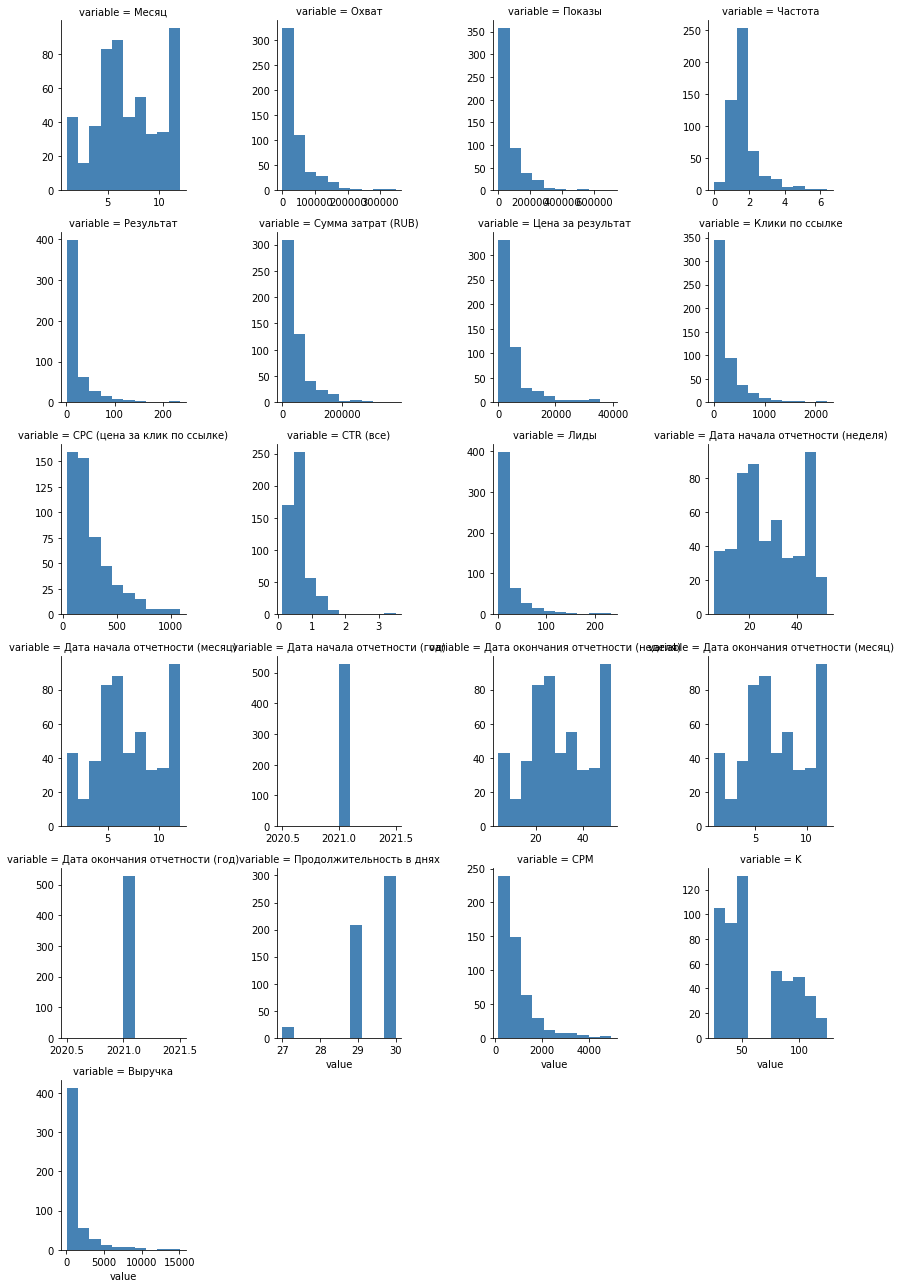

In [43]:
# Visualize distributions of numerical features with histograms
quan = list(data.loc[:, data.dtypes != 'object'].columns.values)
grid = sns.FacetGrid(pd.melt(data, value_vars=quan),
                     col='variable', col_wrap=4, height=3, aspect=1,
                     sharex=False, sharey=False)
grid.map(plt.hist, 'value', color="steelblue")
plt.show()

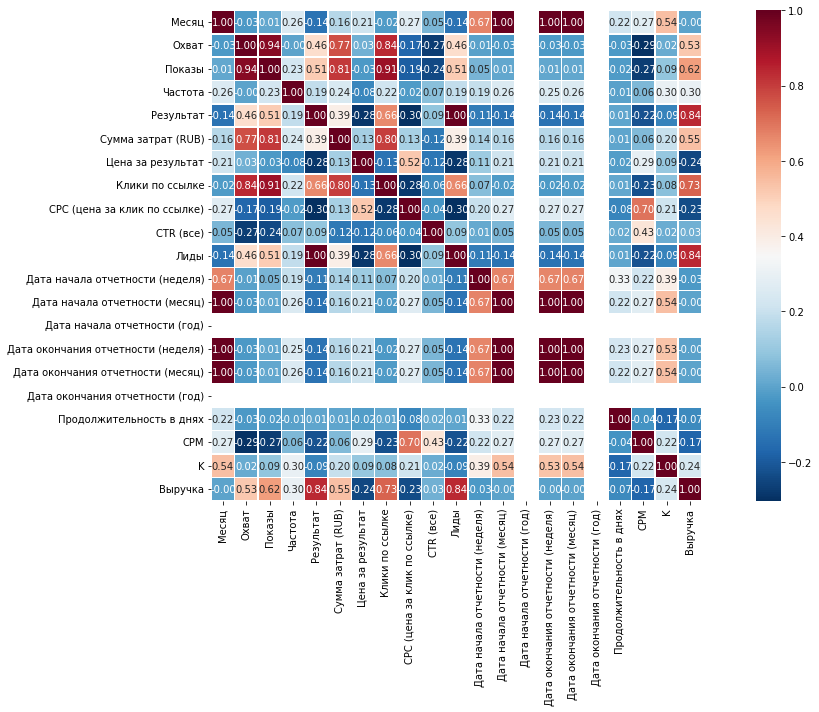

In [44]:
# Visualize feature correlations
sns.heatmap(data._get_numeric_data().astype(float).corr(),
            square=True, cmap='RdBu_r', linewidths=.5,
            annot=True, fmt='.2f').figure.tight_layout()
plt.show()

In [45]:
# Investigate correlations between dependent and independent variables
data.corr(method='pearson').iloc[0].sort_values(ascending=False)

Месяц                                 1.000000
Дата начала отчетности (месяц)        1.000000
Дата окончания отчетности (месяц)     1.000000
Дата окончания отчетности (неделя)    0.999775
Дата начала отчетности (неделя)       0.670066
K                                     0.542397
CPM                                   0.272078
CPC (цена за клик по ссылке)          0.267739
Частота                               0.255932
Продолжительность в днях              0.220853
Цена за результат                     0.211130
Сумма затрат (RUB)                    0.161892
CTR (все)                             0.048291
Показы                                0.008998
Выручка                              -0.000353
Клики по ссылке                      -0.022637
Охват                                -0.027302
Лиды                                 -0.135137
Результат                            -0.135137
Дата начала отчетности (год)               NaN
Дата окончания отчетности (год)            NaN
Name: Месяц, 

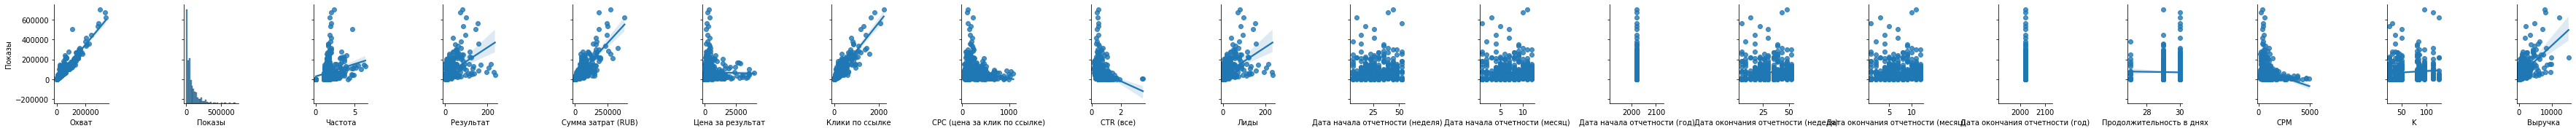

In [46]:
# Visualize correlations between dependent and numerial independent variables
sns.pairplot(data=data, y_vars='Показы', x_vars=quan[1:], kind='reg')
plt.show()

In [47]:
# Investigate missing values
# Columns with NaN
data.isnull().sum()
# Rows with NaN
rows_with_nan = 0
for i in range(len(data)):
    rows_with_nan += data.iloc[i].isnull().sum()
print(rows_with_nan)

50


 <a name="2"></a>
# 2. Preprocessing

In [48]:
def data_pipeline(data, output):
    """
    Preprocessing pipeline part 1: Transform full data frame
    Arguments: Pandas dataframe, output column (dependent variable)
    Returns: Modified dataframe
    """
    # data = cost_per_metric(data, output) if 'cost_per' in output \
    #                                      else data[data[output] > 0]
    # data = drop_columns(data, output, threshold=.5)
    # data = data.dropna(axis='index')
    data = create_other_buckets(data, threshold=.1)
    data_cat = data
    data = one_hot_encode(data)
    return data, data_cat

def split_pipeline(data, output, encoded=True):
    """
    Preprocessing pipeline part 2: Split data into variables
    Arguments: Pandas dataframe, output column (dependent variable)
    Returns: List of scaled and unscaled dependent and independent variables
    """
    y, X = data[output], data.drop([output], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.2, random_state=1)
    if encoded:
        X_scaled, y_scaled, X_train_scaled, y_train_scaled, X_test_scaled, \
            y_scaler = scale(X, y, X_train, y_train, X_test)
        return [X, y, X_train, y_train, X_test, y_test, X_scaled, y_scaled,
                X_train_scaled, y_train_scaled, X_test_scaled, y_scaler]
    return [X, y, X_train, y_train, X_test, y_test]

# def cost_per_metric(data, output):
#     """Create 'cost_per_...' column and remove data where output is 0 or NaN"""
#     metric = output.replace('cost_per_', '') + 's'
#     data = data[data[metric] > 0]
#     data.insert(0, output, [row['cost'] / row[metric]
#                             for index, row in data.iterrows()])
#     return data

def drop_columns(data, output, threshold=0.5):
    """Drop columns with more than threshold missing data"""
    rows = data[output].count()
    for column in list(data.columns):
        if data[column].count() < rows * threshold:
            data = data.drop([column], axis=1)
    return data

def create_other_buckets(data, threshold=0.1):
    """Put rare categorical values into other bucket"""
    categoricals = list(data.select_dtypes(include='object').columns)
    for column in categoricals:
        results = data[column].count()
        groups = data.groupby([column])[column].count()
        for bucket in groups.index:
            if groups.loc[bucket] < results * threshold:
                data.loc[data[column] == bucket, column] = 'other'
    return data

def one_hot_encode(data):
    """One-hot encode categorical data"""
    categoricals = list(data.select_dtypes(include='object').columns)
    for column in categoricals:
        if 'other' in data[column].unique():
            data = pd.get_dummies(data, columns=[column], prefix=[column],
                                  drop_first=False)
            data = data.drop([column + '_other'], axis=1)
        else:
            data = pd.get_dummies(data, columns=[column], prefix=[column],
                                  drop_first=True)
    return data

def scale(X, y, X_train, y_train, X_test):
    """Scale dependent and independent variables"""
    X_scaler, y_scaler = StandardScaler(), StandardScaler()

    X_scaled = X_scaler.fit_transform(X.values.astype(float))
    y_scaled = y_scaler.fit_transform(
        y.values.astype(float).reshape(-1, 1)).flatten()

    X_train_scaled = pd.DataFrame(data=X_scaler.transform(
        X_train.values.astype(float)), columns=X.columns)
    y_train_scaled = y_scaler.transform(
        y_train.values.astype(float).reshape(-1, 1)).flatten()

    X_test_scaled = pd.DataFrame(data=X_scaler.transform(
        X_test.values.astype(float)), columns=X.columns)

    return [X_scaled, y_scaled, X_train_scaled, y_train_scaled,
            X_test_scaled, y_scaler]

<a name="3"></a>
# 3. Regression


In [49]:
sys.path.append('/content/predictor/model') 

In [50]:
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import statsmodels.api as sm
import helpers as hel

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [51]:
# class Stopper:
#     def __init__(self, search, max_stagnations=1):
#         self.best_score = 0
#         self.n_stagnations = 0
#         self.max_stagnations = max_stagnations
#         self.search = search

#     def on_step(self, result):
#         new_best_score = self.search.best_score_
#         # print("New best score: %s" % new_best_score)
#         if new_best_score <= self.best_score:
#             self.n_stagnations += 1
#             if self.n_stagnations > self.max_stagnations:
#                 return True
#         self.best_score = new_best_score


class Regression:
    """
    Regression instance contains functions to build linear, tree, forest and
    SVR models, expects scaled (for SVR) and unscaled (for others) training data
    """
    def __init__(self, X_train, y_train, X_train_scaled, y_train_scaled,
                 X_train_cat, y_train_cat):
        self.X_train = X_train
        self.y_train = y_train
        self.X_train_scaled = X_train_scaled
        self.y_train_scaled = y_train_scaled
        self.X_train_cat = X_train_cat
        self.y_train_cat = y_train_cat
        self.scorer = make_scorer(hel.mean_relative_accuracy)

    def linear(self, verbose=0):
        """
        Construct a linear regressor and calculate the training score using
        training data, 5-fold cross validation and a predefined scorer
        """

        # Output linear regression summary with coefficients and p-values
        # if desired
        if verbose != 0:
            model = sm.OLS(self.y_train_scaled, sm.add_constant(self.X_train_scaled)).fit()
            print(model.summary())

        linear_regressor = LinearRegression(fit_intercept=True, copy_X=True)
        linear_score = np.mean(cross_val_score(
            estimator=linear_regressor, X=self.X_train_scaled, y=self.y_train_scaled,
            cv=5, scoring=self.scorer))
        print('Linear score: ' + str(linear_score))
        return linear_regressor

    def tree(self):
        """
        Construct a decision tree regressor and calculate the training score
        using training data and parameter search with 5-fold cross validation
        """

        # tree_parameters = [{'min_samples_leaf': list(range(2, 10, 1)),
        #                     'criterion': ['mae', 'mse'],
        #                     'random_state': [1]}]
        # tree_search = GridSearchCV(estimator=DecisionTreeRegressor(),
        #                            param_grid=tree_parameters,
        #                            scoring=self.scorer, cv=5, n_jobs=-1,
        #                            iid=False)
        tree_parameters = [{'min_samples_leaf': Integer(2, 10),
                            'criterion': ['mae', 'mse'],
                            'random_state': [1]}]
        tree_search = BayesSearchCV(
            estimator=DecisionTreeRegressor(), search_spaces=tree_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50
        )
        # stopper = Stopper(tree_search)
        # tree_search_result = tree_search.fit(
        #     self.X_train, self.y_train, callback=stopper.on_step)
        tree_search_result = tree_search.fit(
            self.X_train, self.y_train)
        best_tree_parameters = dict(tree_search_result.best_params_)
        tree_score = tree_search_result.best_score_
        print('Best tree params: ' + str(best_tree_parameters))
        print('Tree score: ' + str(tree_score))
        return DecisionTreeRegressor(
            min_samples_leaf=best_tree_parameters['min_samples_leaf'],
            criterion=best_tree_parameters['criterion'],
            random_state=1)

    def forest(self):
        """
        Construct a random forest regressor and calculate the training score
        using training data and parameter search with 5-fold cross validation
        """

        # forest_parameters = [{'n_estimators': hel.powerlist(10, 2, 4),
        #                       'min_samples_leaf': list(range(2, 10, 1)),
        #                       'criterion': ['mae', 'mse'],
        #                       'random_state': [1], 'n_jobs': [-1]}]
        # forest_search = GridSearchCV(estimator=RandomForestRegressor(),
        #                              param_grid=forest_parameters,
        #                              scoring=self.scorer, cv=5, n_jobs=-1,
        #                              iid=False)
        forest_parameters = [{'n_estimators': Integer(10, 200),
                              'min_samples_leaf': Integer(2, 10),
                              'criterion': ['mae', 'mse'],
                              'random_state': [1], 'n_jobs': [-1]}]
        forest_search = BayesSearchCV(
            estimator=RandomForestRegressor(), search_spaces=forest_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50
        )
        # stopper = Stopper(forest_search)
        # forest_search_result = forest_search.fit(
        #     self.X_train, self.y_train, callback=stopper.on_step)
        forest_search_result = forest_search.fit(
            self.X_train, self.y_train)
        best_forest_parameters = dict(forest_search_result.best_params_)
        forest_score = forest_search_result.best_score_
        print('Best forest params: ' + str(best_forest_parameters))
        print('Forest score: ' + str(forest_score))
        return RandomForestRegressor(
            n_estimators=best_forest_parameters['n_estimators'],
            min_samples_leaf=best_forest_parameters['min_samples_leaf'],
            criterion=best_forest_parameters['criterion'],
            random_state=1, n_jobs=-1)

    def svr(self):
        """
        Construct a support vector regressor and calculate the training score
        using scaled training data and parameter search
        with 5-fold cross validation
        """

        # svr_parameters = [{'kernel': ['linear', 'rbf'],
        #                    'C': hel.powerlist(0.1, 2, 10),
        #                    'epsilon': hel.powerlist(0.01, 2, 10),
        #                    'gamma': ['scale']},
        #                   {'kernel': ['poly'],
        #                    'degree': list(range(2, 5, 1)),
        #                    'C': hel.powerlist(0.1, 2, 10),
        #                    'epsilon': hel.powerlist(0.01, 2, 10),
        #                    'gamma': ['scale']}]
        # svr_search = GridSearchCV(estimator=SVR(),
        #                           param_grid=svr_parameters,
        #                           scoring=self.scorer, cv=5, n_jobs=-1,
        #                           iid=False)
        svr_parameters = [{'kernel': ['linear', 'rbf'],
                           'C': Real(0.1, 10),
                           'epsilon': Real(0.01, 1),
                           'gamma': ['scale']},
                          {'kernel': ['poly'],
                           'degree': Integer(2, 5),
                           'C': Real(0.1, 10),
                           'epsilon': Real(0.01, 1),
                           'gamma': ['scale']}]
        svr_search = BayesSearchCV(
            estimator=SVR(), search_spaces=svr_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50
        )
        # stopper = Stopper(svr_search)
        # svr_search_result = svr_search.fit(
        #     self.X_train_scaled, self.y_train_scaled, callback=stopper.on_step)
        svr_search_result = svr_search.fit(
            self.X_train_scaled, self.y_train_scaled)
        best_svr_parameters = dict(svr_search_result.best_params_)
        svr_score = svr_search_result.best_score_
        print('Best SVR params: ' + str(best_svr_parameters))
        print('SVR score: ' + str(svr_score))
        if best_svr_parameters['kernel'] == 'poly':
            svr_regressor = SVR(kernel=best_svr_parameters['kernel'],
                                degree=best_svr_parameters['degree'],
                                C=best_svr_parameters['C'],
                                epsilon=best_svr_parameters['epsilon'],
                                gamma='scale')
        else:
            svr_regressor = SVR(kernel=best_svr_parameters['kernel'],
                                C=best_svr_parameters['C'],
                                epsilon=best_svr_parameters['epsilon'],
                                gamma='scale')
        return svr_regressor

    def xgb(self):
        """
        Construct a gradient boosting regressor and calculate the training score
        using training data and parameter search with 5-fold cross validation
        ! XGBoost library does currently not install on AWS Lambda via Zappa !
        """

        estimator = XGBRegressor(booster='gbtree', objective='reg:squarederror')

        # Bayes Search
        xgb_parameters = {
            'learning_rate': Real(0.05, 0.5),
            'min_split_loss': Real(0.1, 0.5),
            'max_depth': Integer(5, 10),
            'min_child_weight': Integer(1, 5),
            'random_state': [1]
        }
        xgb_search = BayesSearchCV(
            estimator=estimator, search_spaces=xgb_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50
        )
        # stopper = Stopper(xgb_search)
        # xgb_search_result = xgb_search.fit(
        #     self.X_train, self.y_train, callback=stopper.on_step)
        xgb_search_result = xgb_search.fit(
          self.X_train, self.y_train)
        best_xgb_parameters = dict(xgb_search_result.best_params_)
        xgb_score = xgb_search_result.best_score_

        print('Best XGB params: ' + str(best_xgb_parameters))
        print('XGB score: ' + str(xgb_score))

        return XGBRegressor(
            booster='gbtree', objective='reg:squarederror',
            learning_rate=best_xgb_parameters['learning_rate'],
            min_split_loss=best_xgb_parameters['min_split_loss'],
            max_depth=best_xgb_parameters['max_depth'],
            min_child_weight=best_xgb_parameters['min_child_weight'],
            random_state=1)

    def cat(self):
        """
        Construct a gradient boosting regressor and calculate the training score
        using training data and parameter search with 5-fold cross validation
        """

        cats = list(self.X_train_cat.select_dtypes('object').columns)
        estimator = CatBoostRegressor(loss_function='RMSE', cat_features=cats,
                                      random_state=1, verbose=0)

        cat_parameters = {
            'n_estimators': Integer(10, 200),
            'max_depth': Integer(2, 10),
            'learning_rate': Real(0.01, 0.1),
            'random_strength': Real(1, 10),
            'random_state': [1]
        }
        cat_search = BayesSearchCV(
            estimator=estimator, search_spaces=cat_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50
        )
        # stopper = Stopper(cat_search)
        # cat_search_result = cat_search.fit(
        #     self.X_train_cat, self.y_train_cat, callback=stopper.on_step)
        cat_search_result = cat_search.fit(
            self.X_train_cat, self.y_train_cat)
        best_cat_parameters = dict(cat_search_result.best_params_)
        cat_score = cat_search_result.best_score_

        print('Best Cat params: ' + str(best_cat_parameters))
        print('Cat score: ' + str(cat_score))

        return CatBoostRegressor(
            loss_function='RMSE', cat_features=cats,
            n_estimators=best_cat_parameters['n_estimators'],
            max_depth=best_cat_parameters['max_depth'],
            learning_rate=best_cat_parameters['learning_rate'],
            random_strength=best_cat_parameters['random_strength'],
            random_state=1, verbose=0)
        
    def lgbm(self):
        """
        Construct a gradient boosting regressor and calculate the training score
        using training data and parameter search with 5-fold cross validation
        """
        estimator = LGBMRegressor(objective='regression')

        # Bayes Search
        lgbm_parameters = {
            'boosting_type': ['gbdt','dart'],
            'n_estimators': Integer(10, 200),
            'learning_rate': Real(0.05, 0.5),
            'metric': ['l1','l2'],
            'min_gain_to_split': Real(0, 15),
            'max_depth': Integer(5, 10),
            'random_state': [1]
        }
        lgbm_search = BayesSearchCV(
            estimator=estimator, search_spaces=lgbm_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50
        )
        # stopper = Stopper(lgbm_search)
        # lgbm_search_result = lgbm_search.fit(
        #     self.X_train, self.y_train, callback=stopper.on_step)
        lgbm_search_result = lgbm_search.fit(
          self.X_train, self.y_train)
        best_lgbm_parameters = dict(lgbm_search_result.best_params_)
        lgbm_score = lgbm_search_result.best_score_

        print('Best LGBM params: ' + str(best_lgbm_parameters))
        print('LGBM score: ' + str(lgbm_score))

        return LGBMRegressor(
            objective='regression',
            boosting_type=best_lgbm_parameters['boosting_type'], 
            n_estimators=best_lgbm_parameters['n_estimators'],
            learning_rate=best_lgbm_parameters['learning_rate'],
            min_gain_to_split=best_lgbm_parameters['min_gain_to_split'],
            max_depth=best_lgbm_parameters['max_depth'],
            metric=best_lgbm_parameters['metric'], random_state=1)

<a name="4"></a>
# 4. Training

In [52]:
"""
Run train(output) for full pipeline to train, select and save
best model predicting campaign performance, e.g.
python -c 'import training; training.train(output="impressions")'
"""

# Import libraries
# import pandas as pd
# import psycopg2 as pg
# import boto3
# import joblib

# Import secrets
# import config

# Import modules
import helpers as hel
import preprocessing as pre
import regression as reg


# def postgres_to_csv(environment='production'):
#     connection = pg.connect(getattr(config, environment))
#     select = open('campaigns.sql', 'r').read()
#     data = pd.read_sql_query(select, connection)
#     data.to_csv('campaigns.csv', index=False)


# def trim(data, output):
#     """Trim data to only include desired output metric"""
#     if 'cost_per' in output:
#         keep = output.replace('cost_per_', '') + 's'
#     else:
#         keep = output
#     drop_candidates = ['id', 'impressions', 'clicks', 'purchases']
#     drops = [drop for drop in drop_candidates if drop != keep and drop in data.columns]
#     return data.drop(drops, axis=1)


def build(X_train, y_train, X_train_scaled, y_train_scaled,
          X_train_cat, y_train_cat, models):
    """Build and return regression models"""
    # regression = reg.Regression(X_train, y_train, X_train_scaled,
    #                             y_train_scaled, X_train_cat, y_train_cat)
    regression = Regression(X_train, y_train, X_train_scaled,
                                y_train_scaled, X_train_cat, y_train_cat)
    regressors = []
    for model in models:
        regressors.append(getattr(regression, model)())
    return regressors


def evaluate(regressors, X_train, y_train, X_train_scaled, y_train_scaled,
             X_test, y_test, X_test_scaled, y_scaler, X_train_cat, y_train_cat,
             X_test_cat, y_test_cat):
    """
    Evaluate models by fitting on full training set and
    calculating training and test accuracies;
    return best regressor
    """

    training_accuracies = []
    test_accuracies = []
    for regressor in regressors:
        if ('SVR' or 'linear') in str(regressor):
            regressor.fit(X_train_scaled, y_train_scaled)
            training_accuracy = hel.mean_relative_accuracy(
                y_scaler.inverse_transform(regressor.predict(X_train_scaled).reshape(-1,1)).flatten(), y_train)
            test_accuracy = hel.mean_relative_accuracy(
                y_scaler.inverse_transform(regressor.predict(
                    X_test_scaled).reshape(-1,1)).flatten(), y_test)
        elif 'Cat' in str(regressor):
            regressor.fit(X_train_cat, y_train_cat)
            training_accuracy = hel.mean_relative_accuracy(
                regressor.predict(X_train_cat), y_train_cat)
            test_accuracy = hel.mean_relative_accuracy(
                regressor.predict(X_test_cat), y_test_cat)
        else:
            regressor.fit(X_train, y_train)
            training_accuracy = hel.mean_relative_accuracy(
                regressor.predict(X_train), y_train)
            test_accuracy = hel.mean_relative_accuracy(
                regressor.predict(X_test), y_test)

        print(str(regressor).split('(')[0].split('.')[0].replace('<', '') +
              '_train_accu: ' + str(training_accuracy))
        print('**Accuracy on true test**')
        print(str(regressor).split('(')[0].split('.')[0].replace('<', '') +
              '_test_accu: ' + str(test_accuracy))

        training_accuracies.append(training_accuracy)
        test_accuracies.append(test_accuracy)

    return regressors[test_accuracies.index(max(test_accuracies))]


def save(regressor, X, output, stage):
    """Save model and columns to file"""
    joblib.dump(regressor, stage + '_' + 'model.pkl')
    joblib.dump(list(X.columns), stage + '_' + 'columns.pkl')


# def upload_to_s3(output):
#     """Upload model and columns to S3"""
#     s3_connection = boto3.client('s3')
#     bucket_name = 'cpx-prediction'
#     model_file = output + '_model.pkl'
#     model_local = './models/' + model_file
#     columns_file = output + '_columns.pkl'
#     columns_local = './models/' + columns_file
#     s3_connection.upload_file(model_local, bucket_name, model_file)
#     s3_connection.upload_file(columns_local, bucket_name, columns_file)


def print_results(regressor, X_test, X_test_scaled, y_test, y_scaler, X_test_cat, stage):
    """Print actuals and predictions"""
    
    print('*'*10)
    print(f'origin shape is {X_test.shape}')
    print('*'*10)

    # requires changing first condtion
    if ('SVR' or 'linear') in str(regressor):
        predictions = y_scaler.inverse_transform(
            regressor.predict(X_test_scaled).reshape(-1,1)).round(0)
    elif 'Cat' in str(regressor):
      if stage == 'from_budget_to_cpm':
        predictions = regressor.predict(X_test_cat).round(0)
      elif stage == 'from_cpm_to_cpc':
        X_test_cat['CPM'] = pd.read_csv('from_budget_to_cpm.csv', index_col=0).Prediction
        predictions = regressor.predict(X_test_cat).round(0)
      elif stage == 'from_cpc_to_lead':
        X_test_cat['CPM'] = pd.read_csv('from_budget_to_cpm.csv', index_col=0).Prediction
        X_test_cat['CPC (цена за клик по ссылке)'] = pd.read_csv('from_cpm_to_cpc.csv', index_col=0).Prediction
        predictions = regressor.predict(X_test_cat).round(0)
      elif stage == 'from_lead_to_revenue':
        X_test_cat['CPM'] = pd.read_csv('from_budget_to_cpm.csv', index_col=0).Prediction
        X_test_cat['CPC (цена за клик по ссылке)'] = pd.read_csv('from_cpm_to_cpc.csv', index_col=0).Prediction
        X_test_cat['Результат'] = pd.read_csv('from_cpc_to_lead.csv', index_col=0).Prediction
        predictions = regressor.predict(X_test_cat).round(0)


    else:
      if stage == 'from_budget_to_cpm':
        predictions = regressor.predict(X_test).round(0)
      elif stage == 'from_cpm_to_cpc':
        X_test['CPM'] = pd.read_csv('from_budget_to_cpm.csv', index_col=0).Prediction.values
        predictions = regressor.predict(X_test).round(0)
      elif stage == 'from_cpc_to_lead':
        X_test['CPM'] = pd.read_csv('from_budget_to_cpm.csv', index_col=0).Prediction.values
        X_test['CPC (цена за клик по ссылке)'] = pd.read_csv('from_cpm_to_cpc.csv', index_col=0).Prediction.values
        predictions = regressor.predict(X_test).round(0)
      elif stage == 'from_lead_to_revenue':
        X_test['CPM'] = pd.read_csv('from_budget_to_cpm.csv', index_col=0).Prediction
        X_test['CPC (цена за клик по ссылке)'] = pd.read_csv('from_cpm_to_cpc.csv', index_col=0).Prediction
        X_test['Результат'] = pd.read_csv('from_cpc_to_lead.csv', index_col=0).Prediction
        predictions = regressor.predict(X_test).round(0)

    y_t = y_test.round(0)
    print(f'\n### Save {stage} prediction ###')
    result  = pd.DataFrame({'Actual': y_t,'Prediction': predictions})
    result.to_csv(f'{stage}.csv')

    print('\n### Metrics ###')
    print(f'MAPE:{mean_absolute_percentage_error(y_t, predictions)}')
    print(f'R-squared:{r2_score(y_t, predictions)}')
    
    
    print('\n### Results ###')
    print('\nActuals vs Predictions:')
    for actual, prediction in zip(y_t, predictions):
        print(actual, prediction)

    # print('\nPredictions:')
    # for prediction in predictions:
    #     print(prediction)


def train(data, output, stage, update=False, upload=False,
          models=['forest', 'xgb', 'lgbm', 'cat']):
    """Complete training pipeline"""

    # if update:
    #     postgres_to_csv()
    #     print('Data updated.')

    # data = pd.read_csv('/content/predictor/model/impressions.csv')
    # print('Data loaded.')

    # data = trim(data, output)
    # print('Data trimmed.')

    data, data_cat = data_pipeline(data, output)
    [X, y, X_train, y_train, X_test, y_test, X_scaled, y_scaled,
     X_train_scaled, y_train_scaled, X_test_scaled, y_scaler] \
        = split_pipeline(data, output, encoded=True)
    [X_cat, y_cat, X_train_cat, y_train_cat, X_test_cat, y_test_cat] = \
        split_pipeline(data_cat, output, encoded=False)
    print('Data preprocessed.')


    regressors = build(X_train, y_train, X_train_scaled, y_train_scaled,
                       X_train_cat, y_train_cat, models)

    best_regressor = evaluate(regressors, X_train, y_train, X_train_scaled,
                              y_train_scaled, X_test, y_test, X_test_scaled,
                              y_scaler, X_train_cat, y_train_cat, X_test_cat,
                              y_test_cat)
    print('Regressors evaluated. Best regressor is:\n' + str(best_regressor))

    if ('SVR' or 'linear') in str(best_regressor):
        best_regressor.fit(X_scaled, y_scaled)
    elif 'Cat' in str(best_regressor):
        best_regressor.fit(X_cat, y_cat)
    else:
        best_regressor.fit(X, y)
    print('Regressor fit.')

    print_results(best_regressor, X_test, X_test_scaled, y_test, y_scaler, X_test_cat, stage)

    save(best_regressor, X, output, stage)
    print('Regressor saved.')

    # if upload:
    #     upload_to_s3(output)
    #     print('Regressor uploaded.')

In [53]:
stages = ['from_budget_to_cpm', 'from_cpm_to_cpc', 'from_cpc_to_lead', 'from_lead_to_revenue']

In [54]:
s_1 = {'req_cols': ['Месяц', 'Настройка атрибуции', 'Тип результата',\
                    'Сумма затрат (RUB)', 'CPM'],'output':'CPM'}
s_2 = {'req_cols': ['Месяц', 'Настройка атрибуции', 'Тип результата',\
                    'Сумма затрат (RUB)', 'CPM','CPC (цена за клик по ссылке)'],'output':'CPC (цена за клик по ссылке)'}
s_3 = {'req_cols': ['Месяц', 'Настройка атрибуции', 'Тип результата',\
                    'Сумма затрат (RUB)', 'CPM','CPC (цена за клик по ссылке)','Результат'],'output':'Результат'}              
s_4 = {'req_cols': ['Месяц', 'Настройка атрибуции', 'Тип результата',\
                    'Сумма затрат (RUB)', 'CPM','CPC (цена за клик по ссылке)','Результат', 'Выручка'],'output':'Выручка'}                         

In [55]:
d_work_cols = [s_1, s_2, s_3, s_4] 

In [56]:
data = data.dropna(axis='index')
for stage, work_cols in zip(stages, d_work_cols):
  print(f'\n### Now stage is {stage} ###')
  train(data[work_cols['req_cols']], work_cols['output'], stage)


### Now stage is from_budget_to_cpm ###
Data preprocessed.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/pyt

Best forest params: {'criterion': 'mse', 'min_samples_leaf': 3, 'n_estimators': 151, 'n_jobs': -1, 'random_state': 1}
Forest score: 0.5107442828370814


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best XGB params: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'min_split_loss': 0.1, 'random_state': 1}
XGB score: 0.48588547797198156
Best LGBM params: {'boosting_type': 'dart', 'learning_rate': 0.28160525085118127, 'max_depth': 5, 'metric': 'l1', 'min_gain_to_split': 0.0, 'n_estimators': 10, 'random_state': 1}
LGBM score: 0.5030415697322814
Best Cat params: {'learning_rate': 0.08974339740332488, 'max_depth': 10, 'n_estimators': 86, 'random_state': 1, 'random_strength': 1.0}
Cat score: 0.5319779341339588


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor_train_accu: 0.553345648789578
**Accuracy on true test**
RandomForestRegressor_test_accu: 0.45811688648909765
XGBRegressor_train_accu: 0.5297769534686692
**Accuracy on true test**
XGBRegressor_test_accu: 0.44422255542288547
LGBMRegressor_train_accu: 0.38786236853898115
**Accuracy on true test**
LGBMRegressor_test_accu: 0.42624999332369773
catboost_train_accu: 0.45999814018950025
**Accuracy on true test**
catboost_test_accu: 0.450024996486764
Regressors evaluated. Best regressor is:
RandomForestRegressor(criterion='mse', min_samples_leaf=3, n_estimators=151,
                      n_jobs=-1, random_state=1)


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Regressor fit.
**********
origin shape is (103, 5)
**********

### Save from_budget_to_cpm prediction ###

### Metrics ###
MAPE:0.3953397437561733
R-squared:0.590352562752597

### Results ###

Actuals vs Predictions:
217.84 383.0
579.37 754.0
580.83 795.0
1663.62 1616.0
524.91 535.0
314.58 370.0
1538.64 805.0
4958.96 2218.0
750.64 1034.0
2126.93 935.0
605.85 470.0
207.61 367.0
921.6 870.0
436.98 438.0
166.87 566.0
524.49 605.0
371.91 510.0
621.53 618.0
392.92 483.0
519.61 644.0
516.38 600.0
784.49 705.0
772.63 1305.0
373.67 555.0
609.12 665.0
427.16 551.0
572.97 628.0
1547.93 1226.0
2205.08 1560.0
1242.83 1329.0
258.35 335.0
4657.97 2518.0
499.1 485.0
657.05 530.0
1014.56 1627.0
1135.1 906.0
453.11 560.0
1065.84 799.0
3081.69 1750.0
242.9 473.0
293.86 473.0
709.74 1060.0
325.75 673.0
506.6 586.0
910.19 1208.0
1287.31 1361.0
697.28 653.0
2034.5 1370.0
558.25 559.0
1300.64 1135.0
451.06 562.0
438.2 601.0
3042.39 2564.0
992.25 908.0
332.09 352.0
1666.36 1279.0
722.89 659.0
1545.0 1243.0
4

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equival

Best forest params: {'criterion': 'mae', 'min_samples_leaf': 2, 'n_estimators': 165, 'n_jobs': -1, 'random_state': 1}
Forest score: 0.6453042754965196


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

Best XGB params: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'min_split_loss': 0.5, 'random_state': 1}
XGB score: 0.6418316167266693
Best LGBM params: {'boosting_type': 'dart', 'learning_rate': 0.2536780995964902, 'max_depth': 5, 'metric': 'l2', 'min_gain_to_split': 15.0, 'n_estimators': 133, 'random_state': 1}
LGBM score: 0.632511301791222
Best Cat params: {'learning_rate': 0.07842128797169136, 'max_depth': 10, 'n_estimators': 88, 'random_state': 1, 'random_strength': 1.0}
Cat score: 0.6641675543172573


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor_train_accu: 0.7657139971640137
**Accuracy on true test**
RandomForestRegressor_test_accu: 0.6011799494136676
XGBRegressor_train_accu: 0.7425561121217505
**Accuracy on true test**
XGBRegressor_test_accu: 0.5967276522846856
LGBMRegressor_train_accu: 0.7204972038241709
**Accuracy on true test**
LGBMRegressor_test_accu: 0.5971395879625854
catboost_train_accu: 0.7011435252651272
**Accuracy on true test**
catboost_test_accu: 0.6199758997161315
Regressors evaluated. Best regressor is:
Regressor fit.
**********
origin shape is (103, 6)
**********

### Save from_cpm_to_cpc prediction ###

### Metrics ###
MAPE:0.4693114391187442
R-squared:0.5564888793694064

### Results ###

Actuals vs Predictions:
54.35731861 98.0
105.05958333 215.0
118.54399645 308.0
227.958 448.0
82.36674419 120.0
114.86902778 146.0
396.65307692 280.0
588.34029851 563.0
258.92636364 270.0
230.1379798 324.0
212.87047619 154.0
79.82389271 146.0
305.17964286 221.0
219.6570229 164.0
72.93518519 93.0
78.90666

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/pyt

Best forest params: {'criterion': 'mse', 'min_samples_leaf': 2, 'n_estimators': 173, 'n_jobs': -1, 'random_state': 1}
Forest score: 0.45934736126100517
Best XGB params: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'min_split_loss': 0.2136945964245037, 'random_state': 1}
XGB score: 0.428662502741542


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best LGBM params: {'boosting_type': 'gbdt', 'learning_rate': 0.14472783442072018, 'max_depth': 5, 'metric': 'l1', 'min_gain_to_split': 9.803946795472417, 'n_estimators': 10, 'random_state': 1}
LGBM score: 0.3968676057190748
Best Cat params: {'learning_rate': 0.03871611420430095, 'max_depth': 7, 'n_estimators': 134, 'random_state': 1, 'random_strength': 1.5678361227463558}
Cat score: 0.45412116258212515


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor_train_accu: 0.44268244869025
**Accuracy on true test**
RandomForestRegressor_test_accu: 0.0016103071699962168
XGBRegressor_train_accu: 0.3321669499066222
**Accuracy on true test**
XGBRegressor_test_accu: -0.18958428644231562
LGBMRegressor_train_accu: -0.9891069765851708
**Accuracy on true test**
LGBMRegressor_test_accu: -0.8038942099964186
catboost_train_accu: -0.04004889715563231
**Accuracy on true test**
catboost_test_accu: -0.30666651363531594
Regressors evaluated. Best regressor is:
RandomForestRegressor(criterion='mse', min_samples_leaf=2, n_estimators=173,
                      n_jobs=-1, random_state=1)


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Regressor fit.
**********
origin shape is (103, 7)
**********

### Save from_cpc_to_lead prediction ###

### Metrics ###
MAPE:0.750381680761008
R-squared:0.32659841737625794

### Results ###

Actuals vs Predictions:
40.0 20.0
5.0 3.0
74.0 17.0
14.0 13.0
22.0 7.0
84.0 39.0
13.0 12.0
3.0 4.0
7.0 10.0
12.0 9.0
9.0 17.0
37.0 38.0
30.0 14.0
32.0 34.0
3.0 5.0
1.0 6.0
3.0 7.0
6.0 15.0
5.0 6.0
7.0 9.0
2.0 3.0
1.0 4.0
13.0 12.0
21.0 6.0
99.0 90.0
3.0 4.0
9.0 12.0
5.0 13.0
3.0 5.0
2.0 2.0
23.0 17.0
2.0 3.0
44.0 32.0
1.0 3.0
2.0 2.0
2.0 5.0
96.0 8.0
20.0 13.0
10.0 9.0
8.0 7.0
5.0 3.0
1.0 9.0
2.0 8.0
6.0 5.0
5.0 6.0
20.0 22.0
156.0 34.0
5.0 6.0
1.0 5.0
13.0 12.0
12.0 13.0
1.0 2.0
3.0 3.0
4.0 10.0
16.0 11.0
20.0 16.0
6.0 12.0
24.0 20.0
5.0 21.0
6.0 8.0
1.0 2.0
39.0 47.0
55.0 26.0
3.0 3.0
9.0 6.0
134.0 34.0
1.0 2.0
7.0 5.0
13.0 11.0
37.0 6.0
3.0 3.0
5.0 3.0
10.0 10.0
9.0 11.0
20.0 5.0
1.0 2.0
3.0 4.0
3.0 3.0
2.0 6.0
9.0 8.0
14.0 12.0
1.0 4.0
166.0 24.0
3.0 5.0
3.0 2.0
12.0 10.0
129.0 19.0
8.0 14.0
1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/pyt

Best forest params: {'criterion': 'mse', 'min_samples_leaf': 2, 'n_estimators': 34, 'n_jobs': -1, 'random_state': 1}
Forest score: 0.8384315020346758


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best XGB params: {'learning_rate': 0.08510663871413832, 'max_depth': 7, 'min_child_weight': 1, 'min_split_loss': 0.49118669038471774, 'random_state': 1}
XGB score: 0.8709418497873409
Best LGBM params: {'boosting_type': 'dart', 'learning_rate': 0.05, 'max_depth': 10, 'metric': 'l1', 'min_gain_to_split': 15.0, 'n_estimators': 183, 'random_state': 1}
LGBM score: 0.7696990947234659
Best Cat params: {'learning_rate': 0.07045228298526433, 'max_depth': 9, 'n_estimators': 200, 'random_state': 1, 'random_strength': 1.0}
Cat score: 0.7312017481281746


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor_train_accu: 0.9180088568449568
**Accuracy on true test**
RandomForestRegressor_test_accu: 0.8224328708352977
XGBRegressor_train_accu: 0.9811247869017254
**Accuracy on true test**
XGBRegressor_test_accu: 0.8754698714025018
LGBMRegressor_train_accu: 0.8127935318005646
**Accuracy on true test**
LGBMRegressor_test_accu: 0.7399416406002512
catboost_train_accu: 0.8305652934442924
**Accuracy on true test**
catboost_test_accu: 0.6275333113079532
Regressors evaluated. Best regressor is:
XGBRegressor(learning_rate=0.08510663871413832, max_depth=7,
             min_split_loss=0.49118669038471774, objective='reg:squarederror',
             random_state=1)
Regressor fit.
**********
origin shape is (103, 8)
**********

### Save from_lead_to_revenue prediction ###

### Metrics ###
MAPE:0.7492145033286793
R-squared:0.557503247686346

### Results ###

Actuals vs Predictions:
3340.485915492958 2327.0
206.47284335288364 118.0
3731.408633432189 865.0
1572.0402157816798 1429.0
1109.33

In [ ]:
# # from CPM to CPC
# req_cols= ['Месяц', 'Настройка атрибуции', 'Тип результата', 'Сумма затрат (RUB)', 'CPM', 'CPC (цена за клик по ссылке)']
# output = 'CPC (цена за клик по ссылке)'

In [ ]:
# # from CPC to lead
req_cols= ['Месяц', 'Настройка атрибуции', 'Тип результата', 'Сумма затрат (RUB)', 'CPM', 'CPC (цена за клик по ссылке)', 'Результат']
output = 'Результат'

In [ ]:
# train(data[req_cols], output)

In [ ]:
res = pd.read_csv('from_cpc_to_lead.csv', index_col=0)

In [ ]:
res['Complicated'] = pd.read_csv('simple.csv', index_col=0).Prediction

In [ ]:
res.columns = ['actual', 'simple', 'complicated']

In [ ]:
res

NameError: ignored

In [ ]:
 pd.read_csv('from_budget_to_cpm.csv', index_col=0).Prediction

125

In [ ]:
hel.mean_relative_accuracy(res.simple, res.actual)

-9.503619241896157

In [ ]:
hel.mean_relative_accuracy(res.complicated, res.actual)

-0.3434640546227583

Ideas during arriving to work
1. budget --> cpm
2. cpm --> cpc
3. cpc --> leaks

Stupid baseline: budget --> leads

# <a name="5"></a>
# 5. Transfer


In [ ]:
import pandas as pd
import joblib


def get_predictions(output):
    # Load campaign data
    data = pd.read_csv('campaigns.csv')

    # # Trim data to only include desired output metric
    # data = trim(data, output)

    # Preprocess data without train/test or y/X splitting
    data, _ = data_pipeline(data, output)

    # Load primary models
    direct_model = joblib.load('model.pkl')
    direct_columns = joblib.load('columns.pkl')
    cpx_model = \
        joblib.load('./models/' + 'cost_per_' + output[0:-1] + '_model.pkl')
    cpx_columns = \
        joblib.load('./models/' + 'cost_per_' + output[0:-1] + '_columns.pkl')

    # Calculate and save primary predictions
    predictions = pd.DataFrame(columns=[output, 'direct', 'cpx'])
    for index, row in data.iterrows():
        direct_row = pd.DataFrame([dict(row)]) \
                       .reindex(columns=direct_columns, fill_value=0)
        cpx_row = pd.DataFrame([dict(row)]) \
                    .reindex(columns=cpx_columns, fill_value=0)
        direct_prediction = int(direct_model.predict(direct_row)[0])
        cpx_prediction = int(row['cost'] / cpx_model.predict(cpx_row)[0])
        predictions.loc[index] = [row[output], direct_prediction,
                                  cpx_prediction]

    return predictions


def train(output, models=['linear', 'forest', 'svr']):
    data = get_predictions(output)
    print('Primary predictions loaded.')

    [X, y, X_train, y_train, X_test, y_test, X_scaled, y_scaled,
     X_train_scaled, y_train_scaled, X_test_scaled, y_scaler] \
        = split_pipeline(data, output)
    print('Data preprocessed.')

    regressors = build(X_train, y_train, X_train_scaled, y_train_scaled,
                           X_train, y_train, models)
    best_regressor = evaluate(
        regressors, X_train, y_train, X_train_scaled, y_train_scaled,
        X_test, y_test, X_test_scaled, y_scaler, X_train, y_train,
        X_test, y_test)
    print('Regressors evaluated. Best regressor is:\n' + str(best_regressor))

    if 'SVR' in str(best_regressor):
        best_regressor.fit(X_scaled, y_scaled)
    else:
        best_regressor.fit(X, y)
    print('Regressor fit.')

    print_results(best_regressor, X, X_scaled, y, y_scaler, X)

    save(best_regressor, X, output + '_transfer')
    print('Regressor saved.')

    # upload(output + '_transfer')
    # print('Regressor uploaded.')